## Things achieved in this notebook:
- trained a logistic regression model as a baseline model 
- used LOSO cross validation
- calculated subject and event level metrics
- trained other models to try and achieve better performance

There is a huge class imbalance

~9.5% FOG windows. 

Hence Accuracy alone is meaningless
- Use F1, recall, precision

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    precision_score, 
    recall_score,
    RocCurveDisplay, PrecisionRecallDisplay,
    average_precision_score
)

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)

In [25]:
def plot_model_viz(y_true, y_pred, y_score, model_name="", threshold=None):
    """
    y_score: probabilities for positive class OR decision scores
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_score = np.asarray(y_score)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    disp.plot(ax=ax, cmap="Blues", values_format="d", colorbar=False)
    title = f"{model_name} | Confusion Matrix"
    if threshold is not None:
        title += f" (thr={threshold:.2f})"
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

    # ROC
    auc = roc_auc_score(y_true, y_score)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    ax.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    ax.plot([0,1],[0,1],"--")
    ax.set_title(f"{model_name} | ROC Curve")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    # Precision-Recall
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    fig = plt.figure(figsize=(6,5))
    ax = fig.add_subplot(111)
    ax.plot(recall, precision, label=f"AP = {ap:.4f}")
    ax.set_title(f"{model_name} | Precision-Recall Curve")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.legend(loc="lower left")
    plt.tight_layout()
    plt.show()


In [2]:
df = pd.read_csv("merged.csv")

In [3]:
feature_cols = ["rms", "var", "bp_0p5_3", "bp_3_8", "freeze_index"]  
X = df[feature_cols].to_numpy()
y = df["label"].to_numpy()

In [4]:
# creating groups for LOSO
groups = df["subject_id"].to_numpy()
n_subjects = df["subject_id"].nunique() 

In [16]:
# Helper function to convert window labels into episodes

def windows_to_episodes(labels):
    """
    labels: 1D array of 0/1 in time order
    returns: list of (start_idx, end_idx) window indices
    """
    episodes = []
    in_ep = False
    start = None

    for i, v in enumerate(labels):
        if v == 1 and not in_ep:
            in_ep = True
            start = i
        elif v == 0 and in_ep:
            episodes.append((start, i - 1))
            in_ep = False

    if in_ep:
        episodes.append((start, len(labels) - 1))

    return episodes


In [17]:
# Match predicted episodes to true episodes

# A true episode is detected if: ANY predicted episode overlaps it in time

# Helper function for episode recall plus false positives

def episode_metrics(true_eps, pred_eps):
    """
    true_eps, pred_eps: lists of (start, end)
    returns:
        episode_recall
        n_false_positive_episodes
    """
    matched_true = set()
    matched_pred = set()

    for pi, pe in enumerate(pred_eps):
        for ti, te in enumerate(true_eps):
            if not (pe[1] < te[0] or pe[0] > te[1]):
                matched_true.add(ti)
                matched_pred.add(pi)

    recall = len(matched_true) / len(true_eps) if len(true_eps) > 0 else np.nan
    fp_episodes = len(pred_eps) - len(matched_pred)

    return recall, fp_episodes


In [9]:
n_subjects

10

In [5]:
logo = LeaveOneGroupOut()

For each left-out subject:

- StandardScaler.fit(X_train)
- X_train is scaled
- LogisticRegression.fit(X_train_scaled, y_train)
- X_test (left-out subject) is scaled using training mean/std
- Predictions are made
- The test subject never influences scaling or training.
- This prevents data leakage

In [26]:
model = make_pipeline(
    StandardScaler(), # applies z-score normalization. scaling is important for logistic regression
    LogisticRegression(max_iter=2000, class_weight="balanced")  
)

Per-subject results

Example structure:

[
-  {"subject_id": 1, "accuracy": 0.82, "f1": 0.79},
-   {"subject_id": 2, "accuracy": 0.65, "f1": 0.61},
-   {"subject_id": 3, "accuracy": 0.91, "f1": 0.90},

]


This helps us understand

“How well does the model generalize to each individual subject?”

In [23]:
all_y_true, all_y_pred, all_y_prob, all_subjects = [], [], [], []
rows = []
event_rows = []

In [27]:
for train_idx, test_idx in logo.split(X, y, groups):
    subject = groups[test_idx][0]

    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # safer proba extraction: find column for class=1
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)
        if 1 in model.classes_:
            pos_col = np.where(model.classes_ == 1)[0][0]
            y_prob = proba[:, pos_col]
        else:
            y_prob = np.full(len(y_test), np.nan)
    else:
        y_prob = np.full(len(y_test), np.nan)

    all_y_true.append(y_test)
    all_y_pred.append(y_pred)
    all_y_prob.append(y_prob)
    all_subjects.append(np.array([subject] * len(y_test)))

    acc = accuracy_score(y_test, y_pred)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (np.nan,) * 4

    if len(np.unique(y_test)) == 2 and not np.all(np.isnan(y_prob)):
        f1_fog = f1_score(y_test, y_pred, pos_label=1)
        f1_macro = f1_score(y_test, y_pred, average="macro")
        auc = roc_auc_score(y_test, y_prob)
        prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        rec = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    else:
        f1_fog = np.nan
        f1_macro = np.nan
        auc = np.nan
        prec = np.nan
        rec = np.nan

    rows.append({
        "subject_id": subject,
        "n_test": len(test_idx),
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_fog": f1_fog,
        "f1_macro": f1_macro,
        "auc": auc,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    })

 
    # calculating event level metrics
    
    test_df = df.iloc[test_idx].copy()
    test_df["y_pred"] = y_pred

    WINDOW_STEP_SEC = 0.5

    for run_id, run_df in test_df.groupby("run_id"):
        run_df = run_df.sort_values("window_id")

        y_true_run = run_df["label"].to_numpy()
        y_pred_run = run_df["y_pred"].to_numpy()

        true_eps = windows_to_episodes(y_true_run)
        pred_eps = windows_to_episodes(y_pred_run)

        ep_recall, fp_eps = episode_metrics(true_eps, pred_eps)

        duration_min = (len(run_df) * WINDOW_STEP_SEC) / 60.0
        fp_per_min = fp_eps / duration_min if duration_min > 0 else np.nan

        event_rows.append({
            "subject_id": subject,
            "run_id": run_id,
            "episode_recall": ep_recall,
            "fp_per_min": fp_per_min,
            "n_true_episodes": len(true_eps),
            "n_pred_episodes": len(pred_eps)
        })


In [28]:
y_true_all = np.concatenate(all_y_true)
y_pred_all = np.concatenate(all_y_pred)
y_prob_all = np.concatenate(all_y_prob)
subjects_all = np.concatenate(all_subjects)

In [29]:
# Overall scalar metrics
overall_precision = precision_score(y_true_all, y_pred_all, pos_label=1, zero_division=0)
overall_recall = recall_score(y_true_all, y_pred_all, pos_label=1, zero_division=0)
overall_f1 = f1_score(y_true_all, y_pred_all, pos_label=1, zero_division=0)
overall_acc = accuracy_score(y_true_all, y_pred_all)


In [30]:
print("Overall Accuracy:", overall_acc)
print("Overall Precision:", overall_precision)
print("Overall Recall:", overall_recall)
print("Overall F1:", overall_f1)

Overall Accuracy: 0.6506289222744438
Overall Precision: 0.17563916025774268
Overall Recall: 0.724907063197026
Overall F1: 0.28276631344116004


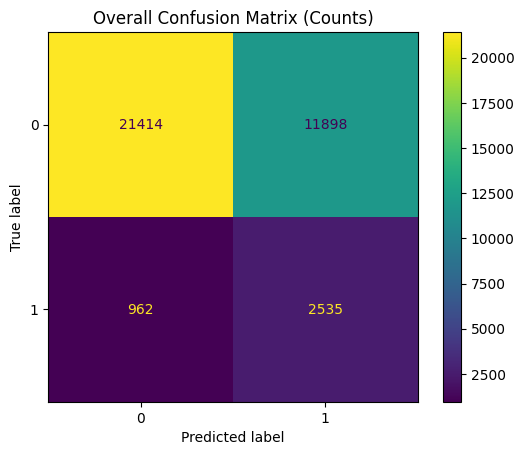

In [31]:
# 1) Confusion Matrix (counts)
cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
fig, ax = plt.subplots()
disp.plot(ax=ax, values_format="d")
ax.set_title("Overall Confusion Matrix (Counts)")
plt.show()

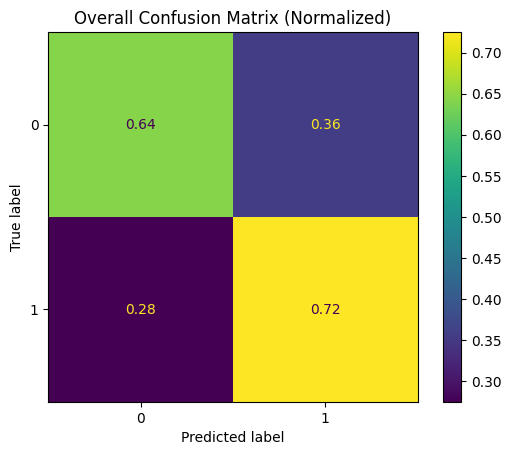

In [32]:
# 2) Confusion Matrix (normalized by true label)
cm_norm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1], normalize="true")
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[0, 1])
fig, ax = plt.subplots()
disp2.plot(ax=ax, values_format=".2f")
ax.set_title("Overall Confusion Matrix (Normalized)")
plt.show()

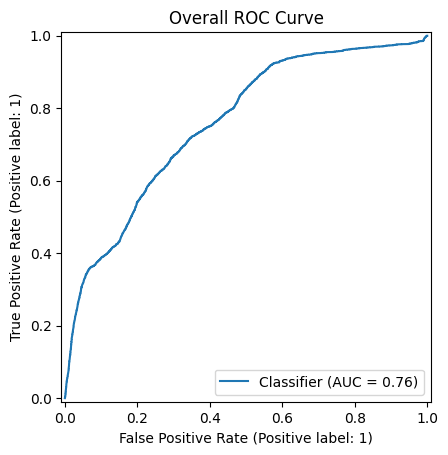

In [36]:
# 3) ROC curve (only if probs available and both classes exist)
if (not np.all(np.isnan(y_prob_all))) and (len(np.unique(y_true_all)) == 2):
    fig, ax = plt.subplots()
    RocCurveDisplay.from_predictions(y_true_all, y_prob_all, ax=ax)
    ax.set_title("Overall ROC Curve")
    plt.show()

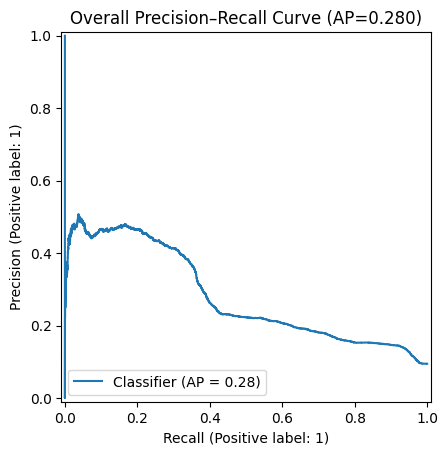

In [37]:
# 4) Precision–Recall curve + AP
if (not np.all(np.isnan(y_prob_all))) and (len(np.unique(y_true_all)) == 2):
    ap = average_precision_score(y_true_all, y_prob_all)
    fig, ax = plt.subplots()
    PrecisionRecallDisplay.from_predictions(y_true_all, y_prob_all, ax=ax)
    ax.set_title(f"Overall Precision–Recall Curve (AP={ap:.3f})")
    plt.show()

- Low precision is expected
- FOG is rare

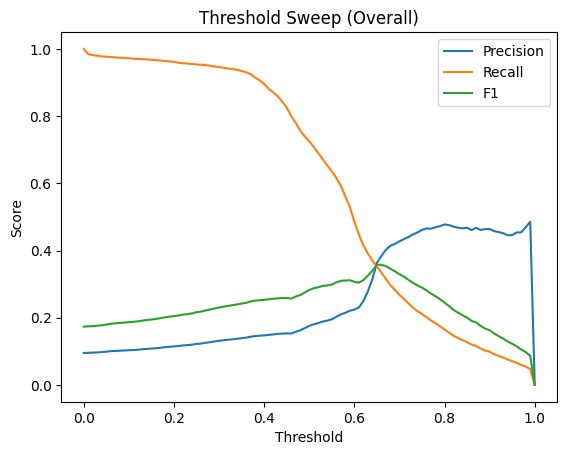

In [38]:
# 5) Threshold sweep: precision/recall/F1 vs threshold
if (not np.all(np.isnan(y_prob_all))) and (len(np.unique(y_true_all)) == 2):
    thresholds = np.linspace(0, 1, 101)
    precs, recs, f1s = [], [], []
    for t in thresholds:
        yp = (y_prob_all >= t).astype(int)
        precs.append(precision_score(y_true_all, yp, pos_label=1, zero_division=0))
        recs.append(recall_score(y_true_all, yp, pos_label=1, zero_division=0))
        f1s.append(f1_score(y_true_all, yp, pos_label=1, zero_division=0))

    fig, ax = plt.subplots()
    ax.plot(thresholds, precs, label="Precision")
    ax.plot(thresholds, recs, label="Recall")
    ax.plot(thresholds, f1s, label="F1")
    ax.set_xlabel("Threshold")
    ax.set_ylabel("Score")
    ax.set_title("Threshold Sweep (Overall)")
    ax.legend()
    plt.show()

In [74]:
per_subject = pd.DataFrame(rows).sort_values("subject_id")

In [75]:
print("Window-level results (subject-wise):")
per_subject

Window-level results (subject-wise):


,subject_id,n_test,accuracy,f1_fog,f1_macro,auc,tn,fp,fn,tp
0,1,3924,0.798165,0.215842,0.550009,0.808262,3023,708,84,109
1,2,2922,0.683436,0.399740,0.592387,0.835021,1689,864,61,308
2,3,4151,0.606360,0.414337,0.558946,0.879765,1939,1628,6,578
3,4,4274,0.589612,NaN,NaN,NaN,2520,1754,0,0
4,5,4316,0.638091,0.453464,0.591470,0.710279,2106,1220,342,648
5,6,4110,0.635036,0.191810,0.478055,0.721190,2432,1416,84,178
6,7,3325,0.330226,0.114513,0.287970,0.859453,954,2226,1,144
7,8,1590,0.661635,0.148734,0.468794,0.449643,1005,170,368,47
8,9,3593,0.611467,0.428337,0.567035,0.828261,1674,1380,16,523
9,10,4604,0.884448,NaN,NaN,NaN,4072,532,0,0


In [53]:
print("\nMacro F1 (mean ± std):",
      np.nanmean(per_subject["f1_macro"]),
      "±",
      np.nanstd(per_subject["f1_macro"], ddof=1))


Macro F1 (mean ± std): 0.5118334095602144 ± 0.10188473770735802


In [54]:
print("FOG F1 (mean ± std):",
      np.nanmean(per_subject["f1_fog"]),
      "±",
      np.nanstd(per_subject["f1_fog"], ddof=1))

FOG F1 (mean ± std): 0.2958472204589532 ± 0.1409048551476684


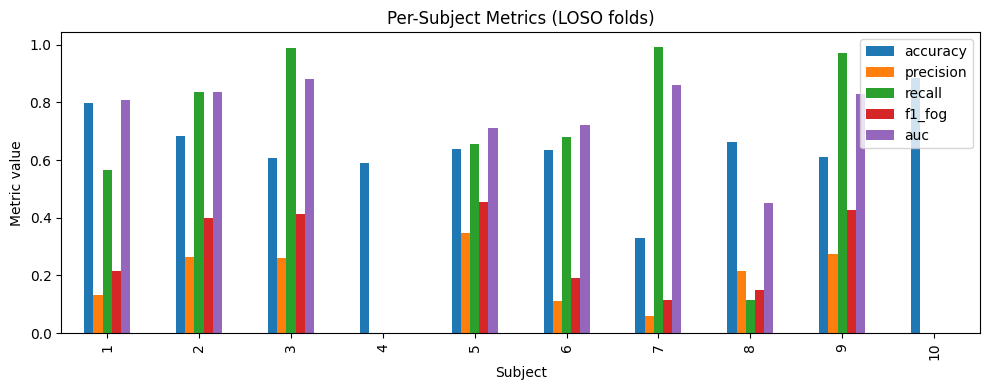

In [42]:
# 7) Per-subject metric bars (from `rows`)
results_df = pd.DataFrame(rows).sort_values("subject_id")

metric_cols = ["accuracy", "precision", "recall", "f1_fog", "auc"]
fig, ax = plt.subplots(figsize=(10, 4))
results_df.set_index("subject_id")[metric_cols].plot(kind="bar", ax=ax)
ax.set_title("Per-Subject Metrics (LOSO folds)")
ax.set_xlabel("Subject")
ax.set_ylabel("Metric value")
ax.legend(loc="best")
plt.tight_layout()
plt.show()

- Large standard deviation (0.144) means that on average, when encountering a new unseen subject, the model classifies ~64% of their samples

- Performance varies a lot between subjects

- Some subjects are easy, others very hard
- F1 score 0.296 ± 0.141 means, the model struggles with the positive class

- Accuracy looks reasonable, but F1 is low → class imbalance
- AUC ≈ 0.76 means the model can rank positives above negatives reasonably well
- Even when F1 is low, AUC being decent means the decision threshold (0.5) may be suboptimal

- Accuracy ranges from 0.33 → 0.88
- F1 ranges from ~0.11 → ~0.45
- AUC ranges from ~0.45 → ~0.88

This reflects
- Different gait styles
- Different FOG phenotypes
- Different amounts of FOG per subject

This is similar to what the original paper reports.

## Event level metrics

A FOG episode is a continuous block of adjacent windows labeled as FOG, and we evaluate whether each true episode was detected at least once, and how many false episodes per minute the system produces.

- FP/min = how many false freezing episodes the system raises per minute of walking, on average.

In [45]:
# Event-level results
event_df = pd.DataFrame(event_rows)

event_subject = (
    event_df
    .groupby("subject_id")[["episode_recall", "fp_per_min"]]
    .mean()
)

print(event_subject)
print("Mean episode recall:", np.nanmean(event_subject["episode_recall"]))
print("Mean FP/min:", np.nanmean(event_subject["fp_per_min"]))

            episode_recall  fp_per_min
subject_id                            
1                 0.950000    2.370030
2                 1.000000    3.645893
3                 1.000000    2.121614
4                      NaN    2.470753
5                 0.876153    2.003066
6                 0.714286    4.073773
7                 1.000000    5.577615
8                 0.428571    1.358491
9                 1.000000    1.970498
10                     NaN    3.622937
Mean episode recall: 0.8711262469414643
Mean FP/min: 2.9214670031962693


- ~87% of true FoG episodes were detected
- On average, the baseline model produces ~3 false freeze alerts every minute

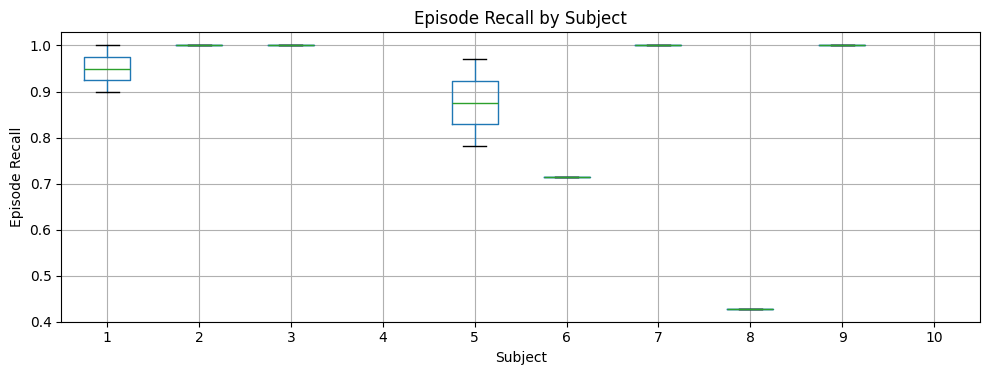

In [46]:
# 8) Event-level visuals (episode_recall, fp_per_min)

fig, ax = plt.subplots(figsize=(10, 4))
event_df.boxplot(column="episode_recall", by="subject_id", ax=ax)
ax.set_title("Episode Recall by Subject")
ax.set_xlabel("Subject")
ax.set_ylabel("Episode Recall")
plt.suptitle("")
plt.tight_layout()
plt.show()

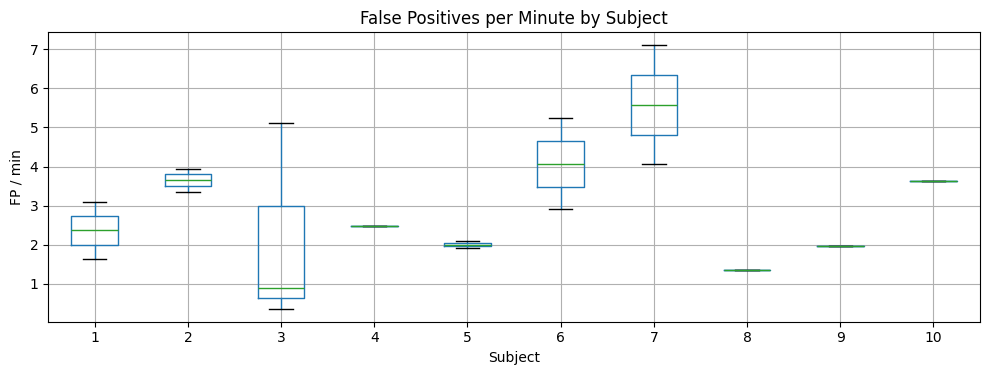

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))
event_df.boxplot(column="fp_per_min", by="subject_id", ax=ax)
ax.set_title("False Positives per Minute by Subject")
ax.set_xlabel("Subject")
ax.set_ylabel("FP / min")
plt.suptitle("")
plt.tight_layout()
plt.show()

## Checking the performance for other models on our data

In [8]:
models = {

    "RandomForest": RandomForestClassifier(
        n_estimators=500,
        max_depth=None,
        min_samples_leaf=10,
        class_weight="balanced_subsample",
        random_state=0,
        n_jobs=-1
    ),
    "HistGB": HistGradientBoostingClassifier(
        learning_rate=0.05,
        max_depth=6,
        max_iter=400,
        random_state=0
    )

}

In [9]:
def eval_model(model):
    all_y_true, all_y_pred, all_y_prob = [], [], []

    for train_idx, test_idx in logo.split(X, y, groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        y_prob = model.predict_proba(X_test)[:, 1]

        all_y_true.append(y_test)
        all_y_pred.append(y_pred)
        all_y_prob.append(y_prob)

    y_true_all = np.concatenate(all_y_true)
    y_pred_all = np.concatenate(all_y_pred)
    y_prob_all = np.concatenate(all_y_prob)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_true_all, y_pred_all)
    f1_fog = f1_score(y_true_all, y_pred_all, pos_label=1)
    f1_macro = f1_score(y_true_all, y_pred_all, average="macro")
    auc = roc_auc_score(y_true_all, y_prob_all)

    return {
        "accuracy": acc,
        "f1_fog": f1_fog,
        "f1_macro": f1_macro,
        "auc": auc,
        "tn": tn, "fp": fp, "fn": fn, "tp": tp
    }



In [10]:
results = []
for name, model in models.items():
    m = eval_model(model)
    m["model"] = name
    results.append(m)

res_df = pd.DataFrame(results).set_index("model").sort_values("f1_fog", ascending=False)
res_df

,accuracy,f1_fog,f1_macro,auc,tn,fp,fn,tp
model,,,,,,,,
RandomForest,0.854927,0.447090,0.681800,0.841452,29310,4002,1338,2159
HistGB,0.902796,0.350399,0.648933,0.843840,32266,1046,2532,965


HistGB has higher accuracy because:
- Most windows are no FoG

- It predicts “no FoG” more often

But clinically:

- Missing a freeze is worse than a false alarm

So accuracy alone should not guide your choice.

Random Forest is better

- Much higher TP (2,159 vs 965)

- Higher FOG F1

- Better episode recall 

Right now both models use threshold = 0.5

Lets try using a smaller threshold for HistGB

In [48]:
model = HistGradientBoostingClassifier(
    learning_rate=0.05,
    max_depth=6,
    max_iter=400,
    random_state=0
)

In [49]:
# Thresholds to try
thresholds = np.linspace(0.2, 0.9, 15)


rows = []


In [50]:
for thr in thresholds:
    subject = groups[test_idx][0]
    all_y_true, all_y_pred, all_y_prob = [], [], []

    for train_idx, test_idx in logo.split(X, y, groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= thr).astype(int)

        all_y_true.append(y_test)
        all_y_pred.append(y_pred)
        all_y_prob.append(y_prob)

    y_true_all = np.concatenate(all_y_true)
    y_pred_all = np.concatenate(all_y_pred)
    y_prob_all = np.concatenate(all_y_prob)

    cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    recall = tp / (tp + fn) if (tp + fn) > 0 else np.nan

    rows.append({
        "threshold": float(thr),
        "accuracy": float(accuracy_score(y_true_all, y_pred_all)),
        "f1_fog": float(f1_score(y_true_all, y_pred_all, pos_label=1)),
        "f1_macro": float(f1_score(y_true_all, y_pred_all, average="macro")),
        "auc": float(roc_auc_score(y_true_all, y_prob_all)),
        "precision_fog": float(precision),
        "recall_fog": float(recall),
        "tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
    })
    


sweep_df = pd.DataFrame(rows).sort_values("threshold").reset_index(drop=True)
sweep_df

,threshold,accuracy,f1_fog,f1_macro,auc,precision_fog,recall_fog,tn,fp,fn,tp
0,0.20,0.847918,0.433401,0.672786,0.84384,0.335422,0.612239,29070,4242,1356,2141
1,0.25,0.866419,0.438763,0.681475,0.84384,0.365122,0.549614,29970,3342,1575,1922
2,0.30,0.880247,0.441884,0.687406,0.84384,0.396501,0.498999,30656,2656,1752,1745
3,0.35,0.889185,0.431973,0.685288,0.84384,0.421010,0.443523,31179,2133,1946,1551
4,0.40,0.896982,0.413548,0.678539,0.84384,0.450320,0.382328,31680,1632,2160,1337
5,0.45,0.901030,0.387216,0.666692,0.84384,0.470180,0.329139,32015,1297,2346,1151
6,0.50,0.902796,0.350399,0.648933,0.84384,0.479861,0.275951,32266,1046,2532,965
7,0.55,0.904887,0.319798,0.634333,0.84384,0.498788,0.235345,32485,827,2674,823
8,0.60,0.905920,0.288766,0.619197,0.84384,0.512391,0.201029,32643,669,2794,703
9,0.65,0.906517,0.243902,0.597041,0.84384,0.526565,0.158707,32813,499,2942,555


- Threshold 0.3 has the best window-level F1
- Reasonable precision

## Calculating metrics at Threshold 0.3 for HistGBM model

In [51]:
y_pred_all = (y_prob_all >= 0.3).astype(int)

In [52]:
# ---------
# 3) Metrics at threshold 0.3
# ---------
cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

acc = accuracy_score(y_true_all, y_pred_all)
prec = precision_score(y_true_all, y_pred_all, pos_label=1, zero_division=0)
rec = recall_score(y_true_all, y_pred_all, pos_label=1, zero_division=0)
f1_pos = f1_score(y_true_all, y_pred_all, pos_label=1, zero_division=0)
f1_macro = f1_score(y_true_all, y_pred_all, average="macro", zero_division=0)

auc = roc_auc_score(y_true_all, y_prob_all)
ap = average_precision_score(y_true_all, y_prob_all)

In [54]:
print(f"Threshold = 0.3")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"Recall     : {rec:.4f}")
print(f"F1 (pos=1) : {f1_pos:.4f}")
print(f"F1 (macro) : {f1_macro:.4f}")
print(f"ROC AUC    : {auc:.4f}")
print(f"PR AP      : {ap:.4f}")
print("Confusion matrix [ [TN FP], [FN TP] ]:")
print(cm)


Threshold = 0.3
Accuracy   : 0.8802
Precision  : 0.3965
Recall     : 0.4990
F1 (pos=1) : 0.4419
F1 (macro) : 0.6874
ROC AUC    : 0.8438
PR AP      : 0.3770
Confusion matrix [ [TN FP], [FN TP] ]:
[[30656  2656]
 [ 1752  1745]]


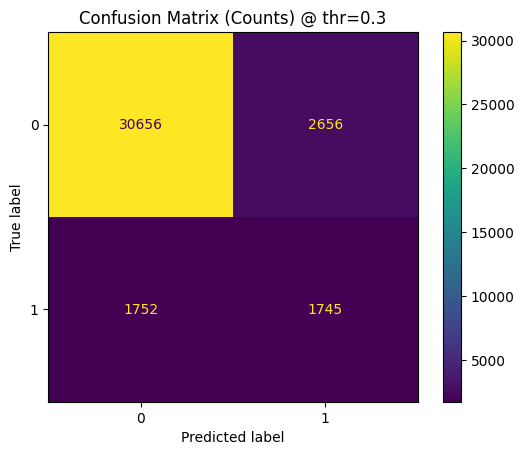

In [56]:
# Confusion Matrix (counts)
fig, ax = plt.subplots()
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1]).plot(
    ax=ax, values_format="d"
)
ax.set_title(f"Confusion Matrix (Counts) @ thr=0.3")
plt.show()

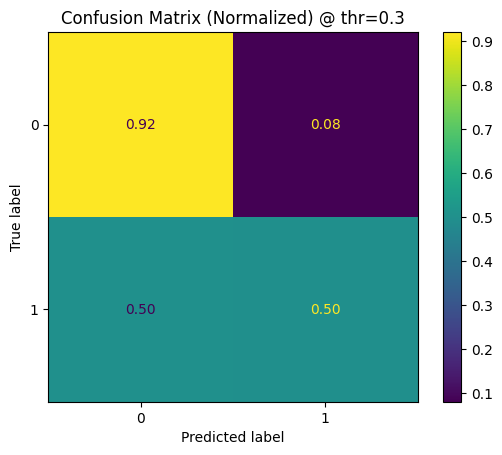

In [58]:
# Confusion Matrix (normalized by true class)
cm_norm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1], normalize="true")
fig, ax = plt.subplots()
ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=[0, 1]).plot(
    ax=ax, values_format=".2f"
)
ax.set_title(f"Confusion Matrix (Normalized) @ thr=0.3")
plt.show()

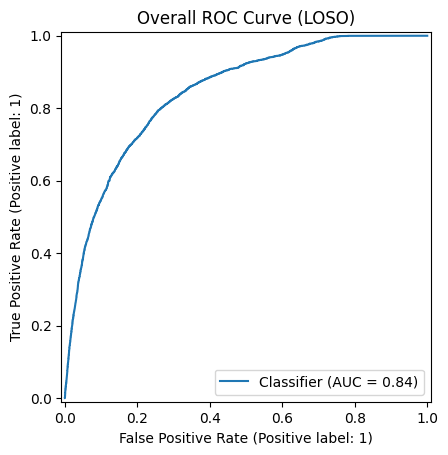

In [59]:
# ROC curve 
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_true_all, y_prob_all, ax=ax)
ax.set_title("Overall ROC Curve (LOSO)")
plt.show()

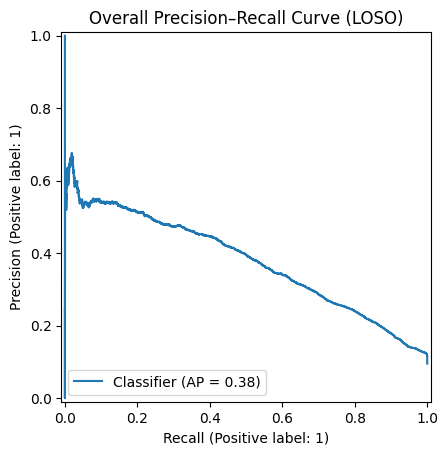

In [60]:
# PR curve 
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(y_true_all, y_prob_all, ax=ax)
ax.set_title("Overall Precision–Recall Curve (LOSO)")
plt.show()